# Бутстреп

In [1]:
import numpy as np
from scipy import stats

from typing import Tuple, List

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

## Метрики и точность их оценивания

Рассмотрим следующую ситуацию. Мы работаем аналитиками и нам нужно оценить статистику (метрику) случайной величины.
Рассмотрим в качестве примера скорость доставки заказов в онлайн-магазине.

Самый простой вариант метрики - __среднее время выполнения заказа__. Для оценки среднего времени выполнения заказа можно взять все заказы за какой-то период времени (_последний месяц_, ...).

Допустим, полученная оценка равна 90 минутам. Насколько ей можно верить?

Для среднего оценка стандартного отклонения вычисляется по формуле:
$$
    \hat{\sigma}_{\overline{X}} = \sqrt{\frac{1}{n(n-1)} \sum_{i=1}^{n}(X_i - \overline{X})^2},
$$
$n$ - размер выборки,
$X_i$ - случайные величины времени доставки,
$\overline{X}$ - выборочное среднее времени доставки.

Рассмотрим пример вычисления оценки среднего и стандартного отклонения. Допустим, что у нас есть информация о 1000 доставках. Распределение времени доставки в реальной жизни может быть произвольным. В примере будем генерировать время доставки из нормального распределения со средним 90 и стандартным отклонением 20. Сгенерируем выборку, оценим среднее и стандартное отклонение среднего.

In [2]:
n = 1000
values = np.random.normal(loc=90, scale=20, size=n)
mean = values.mean()
std = values.std() / np.sqrt(n)

print(f"Оценка среднего времени доставки: {mean:.2f}+/-{std:.2f} мин")

Оценка среднего времени доставки: 89.51+/-0.64 мин


## Квантили

Оценить квантили по имееющейся выборке можем, однако универсальной теоретической формулы для оценки стандартного отклонения квантиля уже нет.
1,000,000 или даже 100 параллельных вселенных у нас нет, чтобы везде посчитать квантили и оценить стандартное отклонение. 

Что делать? Для оценки стандартного отклонения произвольной статистики, в том числе квантиля, есть способ. Бутстреп!

## Бутстреп


__Бутстреп (bootstrap)__ - это метод для оценки стандартных отклонений и нахождения доверительных интервалов статистических функционалов.


Если бы мы могли получать данные из исходного распределения, то могли бы сгенерировать из этого распределения 100 выборок, посчитать по ним 100 квантилей и оценить стандартное отклонение. Истинного распределения мы не знаем, но можем его оценить по имеющимся данным.

В качестве оценки функции распределения будем использовать `эмпирическую функцию распределения` (_ЭФР_). ЭФР является несмещённой оценкой и сходится к истинной ФР при увеличении размера выборки.

`Функция распределения`

Функцией распределения случайной величины $X$ называется функция $\mathcal{F}_X:\mathbb{R} \rightarrow{[0,1]}$, задаваемая формулой $$\mathcal{F}_X(x)=\mathbb{P}(X \leq x)$$

`Эмпирическая функция распределения`

Дана выборка независимых одинаково распределённых случайных величин (_н.о.р.с.в._) $X_1, ..., X_n \sim \mathcal{F}$.

Эмпирической функцией распределения случайных величин $X_1, ..., X_n$ называется функция $\hat{\mathcal{F}_n}(x)=\frac{\sum_{i=1}^{n}I(X_i \leq x)}{n}$, где
$I(X_i \leq x) = \left\{ 1, X_i \leq x; \\ 0, X_i > x \\
\right.$

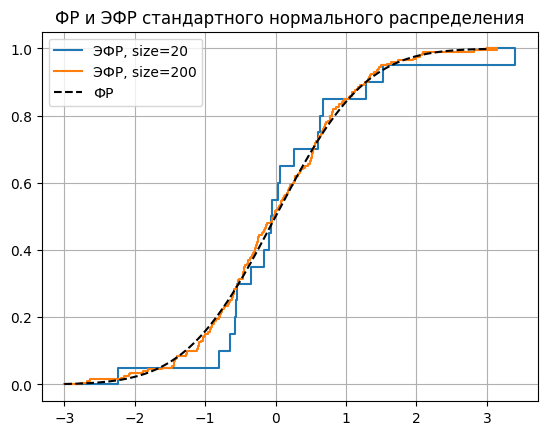

In [3]:
def plot_ecdf(values, label, xlim):
    """Построить график ЭФР."""
    X_ = sorted(set(values))
    Y_ = [np.mean(values <= x) for x in X_]
    X = [xlim[0]] + sum([[v, v] for v in X_], []) + [xlim[1]]
    Y = [0, 0] + sum([[v, v] for v in Y_], [])
    plt.plot(X, Y, label=label)

# Генерируем данные и строим ЭФР
for size in [20, 200]:
    values = np.random.normal(size=size)
    plot_ecdf(values, f'ЭФР, size={size}', [-3, 3])

# Строим ФР
X = np.linspace(-3, 3, 1000)
Y = stats.norm.cdf(X)
plt.plot(X, Y, '--', color='k', label='ФР')

plt.title('ФР и ЭФР стандартного нормального распределения')
plt.legend()
plt.grid()
plt.show()

Хорошо, теперь мы знаемя, что ЭФР "хорошо" приближает истинную ФР. 
Сгенерировать подвыборку размера $n$ из ЭФР - это тоже самое, что выбрать случайно с возвращением $n$ элементов из исходной выборки. Это можно сделать одной строчкой кода:
```python3
np.random.choice(values, size=n, replace=True)
```

Теперь мы можем оценить стандартное отклонение оценки квантиля. Для этого $B$ раз сгенерируем подвыборки из ЭФР, вычислим значение статистики в каждой подвыборке и оценим стандартное отклонение получившихся значений.

In [4]:
n = 1000    # размер исходной подвыборки
B = 1000    # количество подвыборок

values = np.random.normal(loc=90, scale=20, size=n)
quantile = np.quantile(values, .9)
bootstap_quantiles = []

for _ in tqdm(range(B)):
    bootstap_values = np.random.choice(values, size=n, replace=True)
    bootstap_quantiles.append(np.quantile(bootstap_values, .9))
std = np.std(bootstap_quantiles)

print(f"Оценка 90% квантиля: {quantile:.2f}+/-{std:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Оценка 90% квантиля: 114.46+/-1.10


_Важные замечания:_
* Чтобы оценка стандартного отклонения была несмещённой, необходими генерировать выборки такого же размера, как и размер исходной выборки;
* Количество итерация бутстрепа рекомендуется брать в диапазоне $[1000, 10000]$. Этого, как правило, хватает для получения достаточно точных результатов.

## Доверительные интервалы

__Доверительным интервалом__ (_ДИ_) с доверительной вероятностью $1-\alpha$ для параметра $\theta$ называется интервал $C_n=(a,b)$, где $a=a(X_1, ..., X_n)$ и $b=b(X_1, ..., X_n)$ - такие функции выборки, что $\mathbb{P}(\theta \in C_n) \geq 1 - \alpha$

### Нормальный доверительный интервал

Вернёмся к примеру с доставкой из онлайн-магазина и построим ДИ среднего времени доставки. В нашей статье будем использовать 95% доверительный интервал. Если данных много, то, независимо от распределения исходных данных (предполагается, что дисперсия существует и не равна нулю), по центральной предельной теореме среднее будет распределено нормально. Для нормально распределённых статистик ДИ можно вычислить по формуле:
$$
    [\hat{X} - z_{1-\alpha/2}*\hat{std},\ \hat{X}+z_{1-\alpha/2}*\hat{std}]
$$, где
$z_{1-\alpha/2}$ - квантиль стандартного нормального распределения, 
$\alpha$ - уровень значимости.

В нашем примере: $\alpha=0.05$
Такой доверительный интервал называется __нормальным доверительным интервалом__.


Алгоритм:
1. Оценить значение статистики по исходным данным;
2. С помощью бутстрепа оценить стандартной отклонение оценки статистики;
3. По формула ДИ вычислить
$$
    [\hat{pe} - z_{1-\alpha/2}*\hat{std},\ \hat{pe}+z_{1-\alpha/2}*\hat{std}]
$$, 
где $pe$ - point estimation (точечная оценка).

### Перцентильный доверительный интервал

В случае несимметричных распределений мы можем использовать __перцентильный доверительный интервал__. Чтобы построить перцентильный ДИ, нужно отрезать с каждой стороны по $\alpha/2$ площади распределения. Для 95% ДИ нужно отрезать по 2.5%. На практике для вычисления границ ДИ нужно оценить квантиль $q_{\alpha/2}$ и $q_{1-\alpha/2}$ по значениям статистик, полученных с помощью бутстрепа. Доверительный интервал будет иметь вид:
$$
    [\hat{q}_{\alpha/2},\ \hat{q}_{1-\alpha/2}]
$$

### Центральный доверительный интервал

Существует ещё один вариант - __центральный доверительный интервал__:
$$
    [2*\hat{pe} - q_{1-\alpha/2},\ 2*\hat{pe} - q_{\alpha/2}]
$$,
где $pe$ - point estimation (точечная оценка).


### Построение доверительных интервалов

In [5]:
def get_normal_ci(bootstrap_stats: np.ndarray, 
                  pe: float, 
                  alpha: float) -> Tuple[float, float]:
    """Calculates normal confidence interval.
    
    Parameters
    ----------
    bootstrap_stats: `np.ndarray`
        Bootstrap statistic values.
    pe: `float`
        Point estimation.
    alpha: `float`
        Confidence level.
    
    Returns
    -------
    (left, right): `Tuple[float, float]
        Left and Right bound of confidence interval.
    """
    z = stats.norm.ppf(1 - alpha/2)
    se = np.std(bootstrap_stats)
    left, right = pe - z*se, pe + z*se
    return (left, right)

def get_percentile_ci(bootstrap_stats: np.ndarray, 
                      pe: float, 
                      alpha: float) -> Tuple[float, float]:
    """Calculates percentile confidence interval.
    
    Parameters
    ----------
    bootstrap_stats: `np.ndarray`
        Bootstrap statistic values.
    pe: `float`
        Point estimation.
    alpha: `float`
        Confidence level.
    
    Returns
    -------
    (left, right): `Tuple[float, float]
        Left and Right bound of confidence interval.
    """
    left, right = np.quantile(bootstrap_stats, [alpha/2, 1 - alpha/2]) 
    return (left, right)

def get_pivotal_ci(bootstrap_stats: np.ndarray, 
                   pe: float, 
                   alpha: float) -> Tuple[float, float]:
    """Calculates pivotal (central) confidence interval.
    
    Parameters
    ----------
    bootstrap_stats: `np.ndarray`
        Bootstrap statistic values.
    pe: `float`
        Point estimation.
    alpha: `float`
        Confidence level.
    
    Returns
    -------
    (left, right): `Tuple[float, float]
        Left and Right bound of confidence interval
    """
    left, right = 2*pe - np.quantile(bootstrap_stats, [1 - alpha/2, alpha/2])
    return (left, right)

In [13]:
# Data parameters
n = 1000
B = 10000
alpha = 0.05
# Data
values = np.random.normal(loc=90, scale=20, size=n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = np.quantile(np.random.choice(values, (B, n), replace=True), 0.9, axis=1)
# Confidence interval
normal_ci = get_normal_ci(bootstrap_quantiles, quantile, alpha)
percentile_ci = get_percentile_ci(bootstrap_quantiles, quantile, alpha)
pivotal_ci = get_pivotal_ci(bootstrap_quantiles, quantile, alpha)

In [16]:
from sklearn.metrics import roc_auc_score

In [29]:
(np.random.choice(values, (3, 10), replace=True) % 2).astype(int)

array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 0, 1]])

In [41]:
y_true = np.random.randint(2, size=10)
y_pred = (np.random.choice(values, (3, 10), replace=True) % 2).astype(int)
bootstrap_roc_auc = [roc_auc_score(y_true, bootstrap_sample)for bootstrap_sample in y_pred]
np.mean(bootstrap_roc_auc), bootstrap_roc_auc

(0.42857142857142855,
 [0.30952380952380953, 0.4523809523809524, 0.5238095238095238])

In [46]:
np.empty(10)

array([5.e-324, 5.e-324, 5.e-324, 5.e-324, 5.e-324, 5.e-324, 5.e-324,
       0.e+000, 0.e+000, 0.e+000])

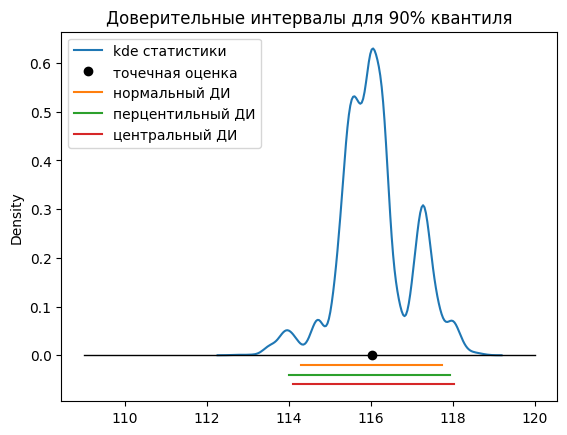

In [23]:
sns.kdeplot(bootstrap_quantiles, label='kde статистики')
plt.plot([quantile], [0], 'o', c='k', markersize=6, label='точечная оценка')
plt.plot([109, 120], [0, 0], 'k', linewidth=1)
d = 0.02
plt.plot(normal_ci, [-d, -d], label='нормальный ДИ')
plt.plot(percentile_ci, [-d*2, -d*2], label='перцентильный ДИ')
plt.plot(pivotal_ci, [-d*3, -d*3], label='центральный ДИ')

plt.title('Доверительные интервалы для 90% квантиля')
plt.legend()
plt.show()